In [1]:
import os
import sys

root_folder = os.path.dirname(os.path.abspath(''))
if not root_folder in sys.path: sys.path.append(root_folder)

In [2]:
from pathlib import Path
import pickle

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error

from src import read_trips, process_trips

In [3]:
DATA_DIR = Path("../data")
MODEL_DIR = Path("../models")
MODEL_DIR.mkdir(parents=True, exist_ok=True)

# Train a linear model

The goal is to train a linear model that predicts the duration of a trip based on the start and end locations, and trip distance.

## Read the data

In [4]:
trips = read_trips(DATA_DIR, "green", "2021", "01")

## Feature Engineering

In this section, we will create relevant features for our model.

In [5]:
# Get duration in minutes
trips["duration"] = trips["lpep_dropoff_datetime"] - trips["lpep_pickup_datetime"]
trips["duration"] = trips["duration"].apply(lambda td: td.total_seconds() / 60)

# Remove outliers
trips = trips[(trips["duration"] >= 1) & (trips["duration"] <= 60)]

# Concatenate pickup and dropoff location
trips["PU_DO"] = trips["PULocationID"].astype(str) + "_" + trips["DOLocationID"].astype(str)

In this step,  we transform the data into a format that can be used by the model.

In [6]:
target = "duration"
categorical_columns = ["PU_DO"]
numerical_columns = ["trip_distance"]
used_cols = categorical_columns + numerical_columns

# Since linear models takes only numerical data, we need to vectorize categorical features into numbers.
dv = DictVectorizer()
X_train = dv.fit_transform(trips[used_cols].to_dict(orient="records"))
y_train = trips[target]

## Train the linear model

In [7]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

mean_squared_error(y_train, y_pred, squared=False)

5.699564118198945

## Compate the distribution of predicted and actual values

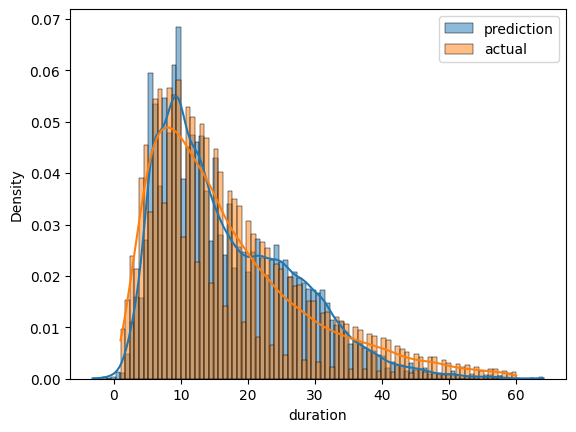

In [8]:
sns.histplot(y_pred, label="prediction", kde=True, stat="density")
sns.histplot(y_train, label="actual", kde=True, stat="density")

plt.legend()

# Train a linear model and apply it to a test set

In the previous example, we trained a linear model on a dataset, and evaluated it on the same set. In this example, we'll evaluate the model on a different dataset, which the model has not seen during training.

In [9]:
trips_train = read_trips(DATA_DIR, "green", "2021", "01")
trips_test = read_trips(DATA_DIR, "green", "2021", "02")

# We can group the code that creates relevant features into process_trips().
trips_train = process_trips(trips_train)
trips_test = process_trips(trips_test)

len(trips_train), len(trips_test)

Standard deviation of duration: 59.34
Fraction of the records left after dropping the outliers: 0.9658903787344154
Standard deviation of duration: 53.17
Fraction of the records left after dropping the outliers: 0.9589450535835966


(73908, 61921)

In [10]:
target = "duration"
categorical_cols = ["PU_DO"]
numerical_cols = ["trip_distance"]
used_cols = categorical_cols + numerical_cols

dv = DictVectorizer()

X_train = dv.fit_transform(trips_train[used_cols].to_dict(orient="records"))
y_train = trips_train[target]

X_val = dv.transform(trips_test[used_cols].to_dict(orient="records"))
y_val = trips_test[target]

In [11]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

7.758715206931833

As the the model has not seen the test set before, the mean squared error (MSE) on the test set is *USUALLY (NOT ALWAYS)* higher than on the training set.

## Save the vectorizer and the prediction model

In [12]:
with open(MODEL_DIR / "lin_reg.bin", "wb") as f_out:
    pickle.dump((dv, lr), f_out)

## Train a linear model with regularization (Lasso)

We can also train a linear model with regularization, which can be useful to avoid overfitting. In this example, we'll use the Lasso model, which adds a penalty to the size of the coefficients.

In [13]:
lr = Lasso(0.01)
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

11.167275941179728

# (Optional) Use Pipeline to chain the process

We can use Pipeline to chain the process of feature engineering and training a model.

In [14]:
from sklearn.pipeline import Pipeline

In [15]:
pipe = Pipeline([("vectorizer", DictVectorizer()), ("predictor", LinearRegression())])

In [16]:
# Note that X_train and X_test are dictionaries, not the transformed matrices in the previous example
X_train = trips_train[used_cols].to_dict(orient="records")
y_train = trips_train[target]

X_test = trips_test[used_cols].to_dict(orient="records")
y_test = trips_test[target]

pipe.fit(X_train, y_train)

Pipeline(steps=[('vectorizer', DictVectorizer()),
                ('predictor', LinearRegression())])

In [17]:
mean_squared_error(pipe.predict(X_test), y_test, squared=False)

7.758715206931833

In [18]:
# By using the pipeline, we can easily change the model. For example, we can use Lasso instead of LinearRegression.
pipe = Pipeline([("vectorizer", DictVectorizer()), ("predictor", Lasso(0.01))])
pipe.fit(X_train, y_train)

Pipeline(steps=[('vectorizer', DictVectorizer()),
                ('predictor', Lasso(alpha=0.01))])

In [19]:
mean_squared_error(pipe.predict(X_test), y_test, squared=False)

11.167275941179728

# Homework

In [20]:
import numpy as np
from sklearn.pipeline import Pipeline

In [21]:
trips_train = read_trips(DATA_DIR, "yellow", "2022", "01")
print(f"Number of columns: {trips_train.shape[1]}")
trips_train = process_trips(trips_train)

Number of columns: 19
Standard deviation of duration: 46.45
Fraction of the records left after dropping the outliers: 0.9827547930522406


In [22]:
target = "duration"
used_cols = ["PULocationID", "DOLocationID"]

X_train = trips_train[used_cols].to_dict(orient="records")
y_train = trips_train[target]

In [23]:
pipe = Pipeline([("vectorizer", DictVectorizer()), ("predictor", LinearRegression())])
pipe.fit(X_train, y_train)

Pipeline(steps=[('vectorizer', DictVectorizer()),
                ('predictor', LinearRegression())])

In [24]:
mean_squared_error(pipe.predict(X_train), y_train, squared=False)

6.986190814952337

In [25]:
trips_test = read_trips(DATA_DIR, "yellow", "2022", "02")
trips_test = process_trips(trips_test)

Standard deviation of duration: 47.26
Fraction of the records left after dropping the outliers: 0.979444397269143


In [26]:
X_test = trips_test[used_cols].to_dict(orient="records")
y_test = trips_test[target]

In [27]:
mean_squared_error(pipe.predict(X_test), y_test, squared=False)

7.786407163179794